In [1]:
# fix python path if working locally
# from utils import fix_pythonpath_if_working_locally

# fix_pythonpath_if_working_locally()

# import warnings

# warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

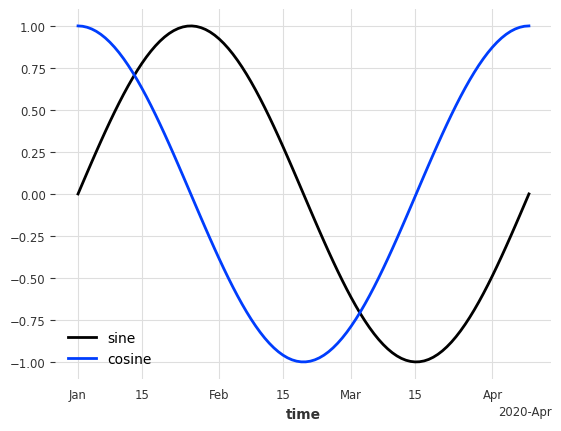

In [3]:
from darts import TimeSeries
from darts.utils.utils import generate_index

# generate a sine and cosine wave
x = np.linspace(0, 2 * np.pi, 100)
sine_vals = np.sin(x)
cosine_vals = np.cos(x)

# generate a DatetimeIndex with daily frequency
dates = generate_index("2020-01-01", length=len(x), freq="D")

# create a DataFrame; here we use pandas but you can use any other backend (e.g. polars, pyarrow, ...).
df = pd.DataFrame({"sine": sine_vals, "cosine": cosine_vals, "time": dates})

series = TimeSeries.from_dataframe(df, time_col="time")
series.plot();

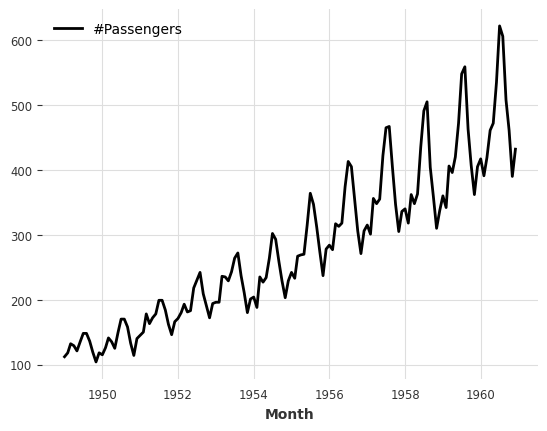

In [4]:
from darts.datasets import AirPassengersDataset

series = AirPassengersDataset().load()
series.plot();

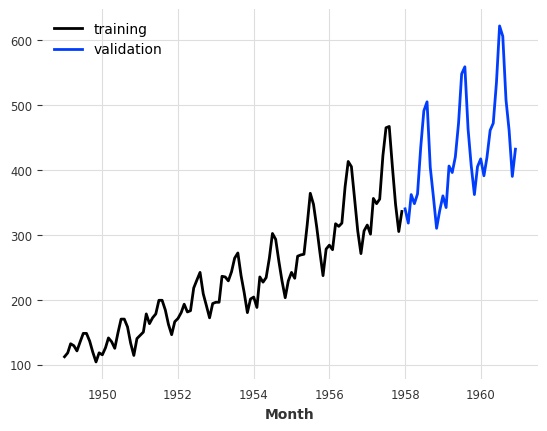

In [5]:
# create a train and validation split

train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation");

/home/mo/Code/YouBikeLive/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


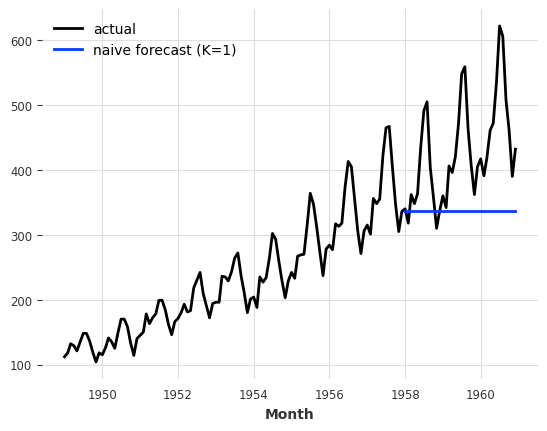

In [6]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)");

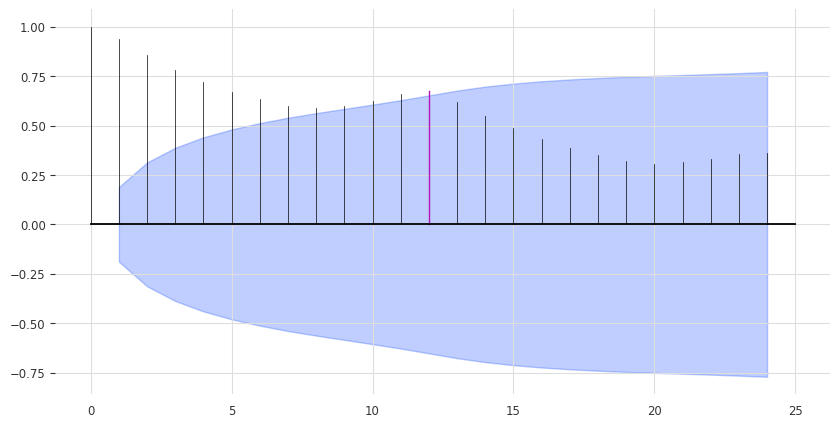

In [7]:
from darts.utils.statistics import check_seasonality, plot_acf

plot_acf(train, m=12, alpha=0.05, max_lag=24)

In [8]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print(f"There is seasonality of order {period}.")

There is seasonality of order 12.


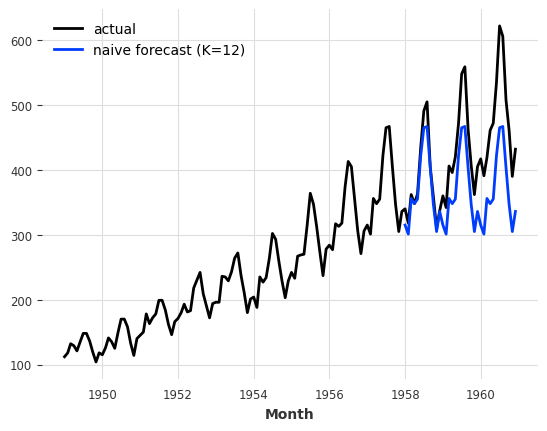

In [9]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)");

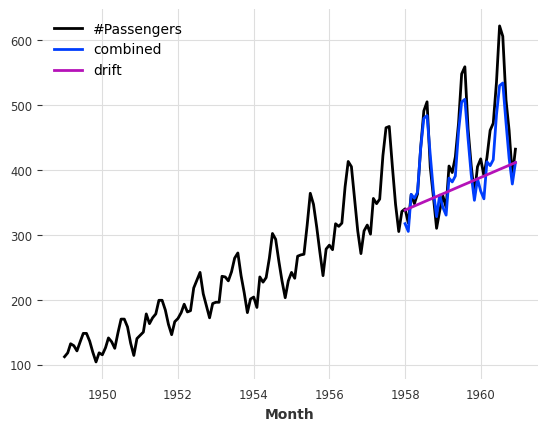

In [10]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift");

In [11]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


In [12]:
# evaluate multiple models

from darts.models import AutoARIMA, ExponentialSmoothing, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print(f"model {model} obtains MAPE: {mape(val, forecast):.2f}%")


eval_model(ExponentialSmoothing())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 5.11%


/home/mo/Code/YouBikeLive/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mo/Code/YouBikeLive/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mo/Code/YouBikeLive/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mo/Code/YouBikeLive/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mo/Code/YouBikeLive/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed 

model AutoARIMA() obtains MAPE: 11.65%
model Theta() obtains MAPE: 8.15%


/home/mo/Code/YouBikeLive/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mo/Code/YouBikeLive/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: xlabel='Month'>

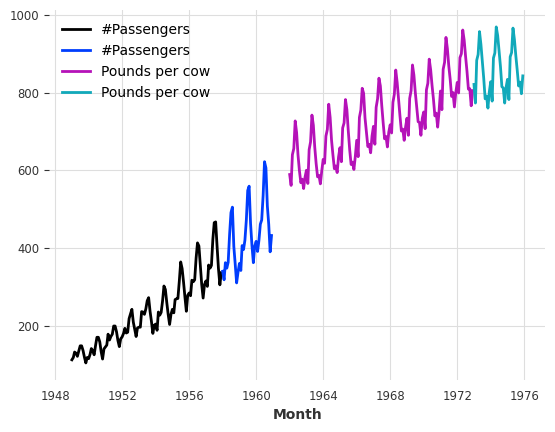

In [13]:
# deep learning part

from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

<Axes: xlabel='Month'>

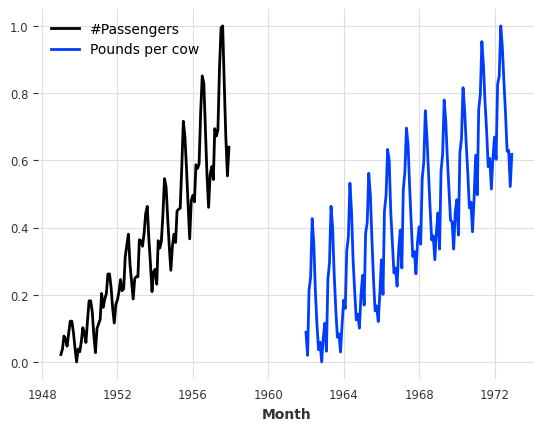

In [14]:
# scale between 0 to 1 to benefit ml models

from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

In [15]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
--------------------

Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 22.83it/s, train_loss=0.00182] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 22.74it/s, train_loss=0.00182]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, random_state=42)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.70it/s]


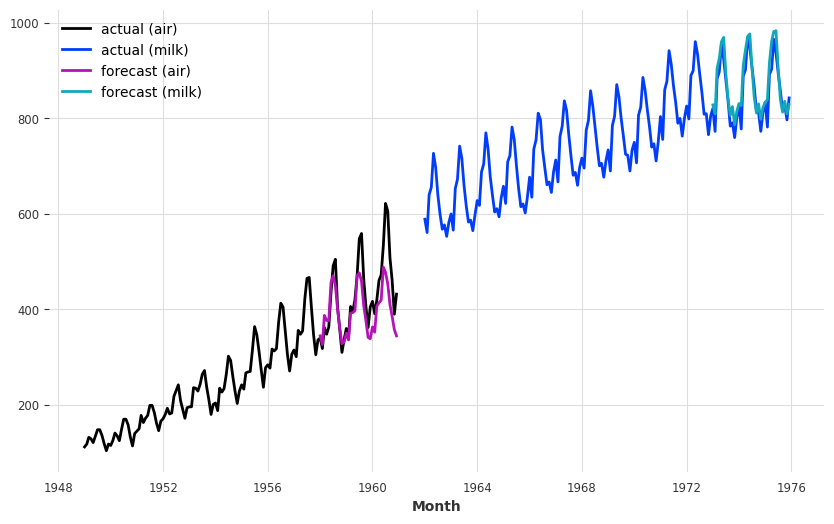

In [16]:
pred_air, pred_milk = model.predict(series=[train_air_scaled, train_milk_scaled], n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)");

In [17]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 23.11it/s, train_loss=0.00182] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 23.02it/s, train_loss=0.00182]


In [18]:
# produce forecasts

preds = model.predict(
    series=[train_air_scaled, train_milk_scaled],
    past_covariates=[air_covs_scaled, milk_covs_scaled],
    n=36,
)

# scale back:
pred_air, pred_milk = scaler.inverse_transform(preds)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)");

NameError: name 'air_covs_scaled' is not defined

In [19]:
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    add_encoders=encoders,
    random_state=42,
)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);


NameError: name 'encoders' is not defined

In [ ]:
# build some covariates

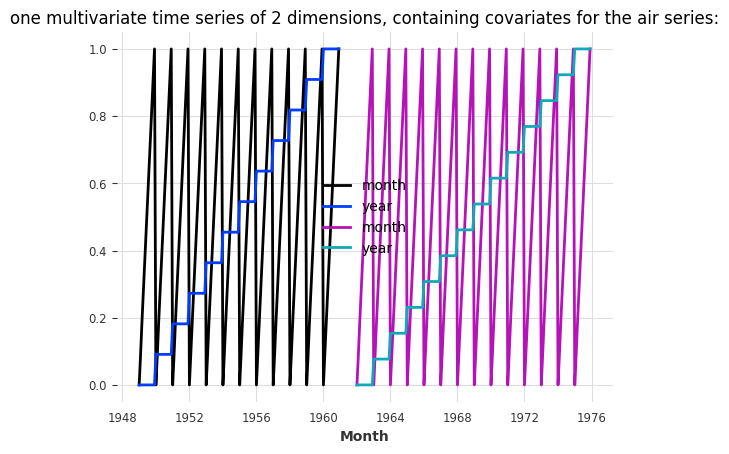

In [22]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series_air, "month", dtype=np.float32),
        dt_attr(series_air, "year", dtype=np.float32),
    ],
    axis="component",
)

milk_covs = concatenate(
    [
        dt_attr(series_milk, "month", dtype=np.float32),
        dt_attr(series_milk, "year", dtype=np.float32),
    ],
    axis="component",
)

air_covs_scaled, milk_covs_scaled = Scaler().fit_transform([air_covs, milk_covs])
air_covs_scaled.plot()
milk_covs_scaled.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
);

In [23]:
# let's try regression models on our data from darts

from sklearn.linear_model import BayesianRidge

from darts.models import RegressionModel

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled],
    future_covariates=[air_covs_scaled, milk_covs_scaled],
);


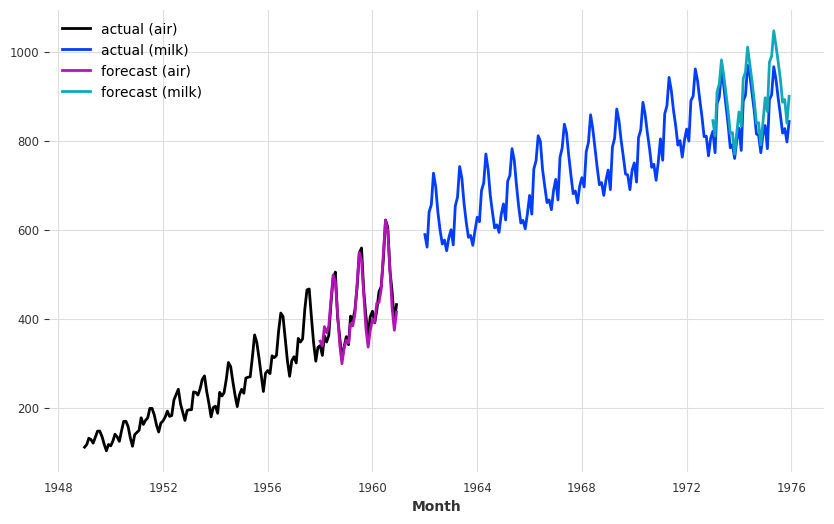

In [24]:
preds = model.predict(
    series=[train_air_scaled, train_milk_scaled],
    future_covariates=[air_covs_scaled, milk_covs_scaled],
    n=36,
)

# scale back:
pred_air, pred_milk = scaler.inverse_transform(preds)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)");